<a href="https://colab.research.google.com/github/Isdra77/VisionArtificial/blob/Pr%C3%A1ctica-6/Copia_de_Deteccion_de_objetos_con_Faster_Rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar Dependencias

In [1]:
!pip install torch torchvision
!pip install opencv-python
!pip install matplotlib
!pip install pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Importar Librerias

In [2]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time
import os
from IPython.display import display, clear_output
from google.colab.patches import cv2_imshow

# Verificar GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# Cargar modelo "Faster R-CNN" pre-entrenado con COCO Dataset

In [4]:
def cargar_modelo():
    # Cargar modelo preentrenado con pesos optimizados
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    model.eval()  # Establecer en modo evaluación
    model.to(device)  # Mover modelo a GPU si está disponible

    # Obtener categorías de COCO
    categories = weights.meta["categories"]
    print(f"Modelo cargado con {len(categories)} categorías")
    return model, categories

modelo, categorias = cargar_modelo()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 95.4MB/s]


Modelo cargado con 91 categorías


# Funciones Auxliares

In [5]:
def preparar_imagen(imagen):
    # Convertir imagen a tensor y normalizar
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Si la entrada es una ruta de archivo o una URL
    if isinstance(imagen, str):
        if imagen.startswith('http'):
            response = requests.get(imagen)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(imagen).convert('RGB')
    # Si la entrada es una matriz NumPy (desde OpenCV)
    elif isinstance(imagen, np.ndarray):
        # Convertir de BGR (OpenCV) a RGB
        img = Image.fromarray(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    else:
        img = imagen

    return img, transform(img).unsqueeze(0).to(device)

In [6]:
def detectar_objetos(modelo, imagen, categorias, umbral_confianza=0.5):
    # Preparar imagen
    img_original, img_tensor = preparar_imagen(imagen)

    # Obtener predicciones
    with torch.no_grad():
        predicciones = modelo(img_tensor)

    # Extraer resultados
    boxes = predicciones[0]['boxes'].cpu().numpy().astype(np.int32)
    labels = predicciones[0]['labels'].cpu().numpy()
    scores = predicciones[0]['scores'].cpu().numpy()

    # Filtrar por umbral de confianza
    indices = np.where(scores > umbral_confianza)[0]
    boxes_filtradas = boxes[indices]
    labels_filtradas = labels[indices]
    scores_filtradas = scores[indices]

    return img_original, boxes_filtradas, labels_filtradas, scores_filtradas

In [7]:
def visualizar_detecciones(imagen, cajas, etiquetas, puntuaciones, categorias):
    # Convertir a array numpy para manipulación con OpenCV
    img_np = np.array(imagen)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # Colores aleatorios para cada clase
    np.random.seed(42)  # Para reproducibilidad
    colors = np.random.randint(0, 255, size=(len(categorias), 3), dtype=np.uint8)

    # Dibujar cajas delimitadoras
    for caja, etiqueta, puntuacion in zip(cajas, etiquetas, puntuaciones):
        # Obtener coordenadas
        x1, y1, x2, y2 = caja

        # Obtener color para la clase
        color = tuple(map(int, colors[etiqueta]))

        # Dibujar rectángulo
        cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)

        # Preparar texto con clase y puntuación
        texto = f"{categorias[etiqueta]}: {puntuacion:.2f}"

        # Calcular posición del texto
        text_size = cv2.getTextSize(texto, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]

        # Dibujar fondo para el texto
        cv2.rectangle(img_np, (x1, y1 - text_size[1] - 5), (x1 + text_size[0], y1), color, -1)

        # Dibujar texto
        cv2.putText(img_np, texto, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Mostrar imagen resultado
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return img_np

# Inferencia del Modelo

Procesando imagen: https://github.com/pytorch/hub/raw/master/images/dog.jpg


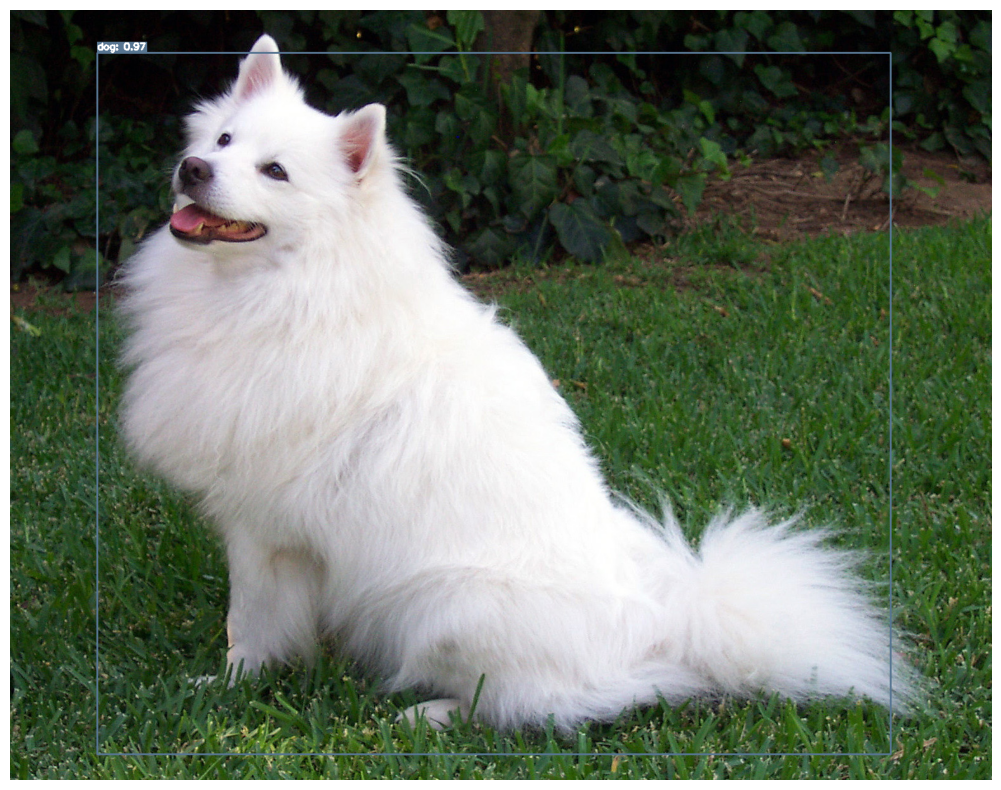

Detecciones realizadas: 1
Objetos encontrados:
- dog: 0.97


Procesando imagen: https://raw.githubusercontent.com/pjreddie/darknet/master/data/person.jpg


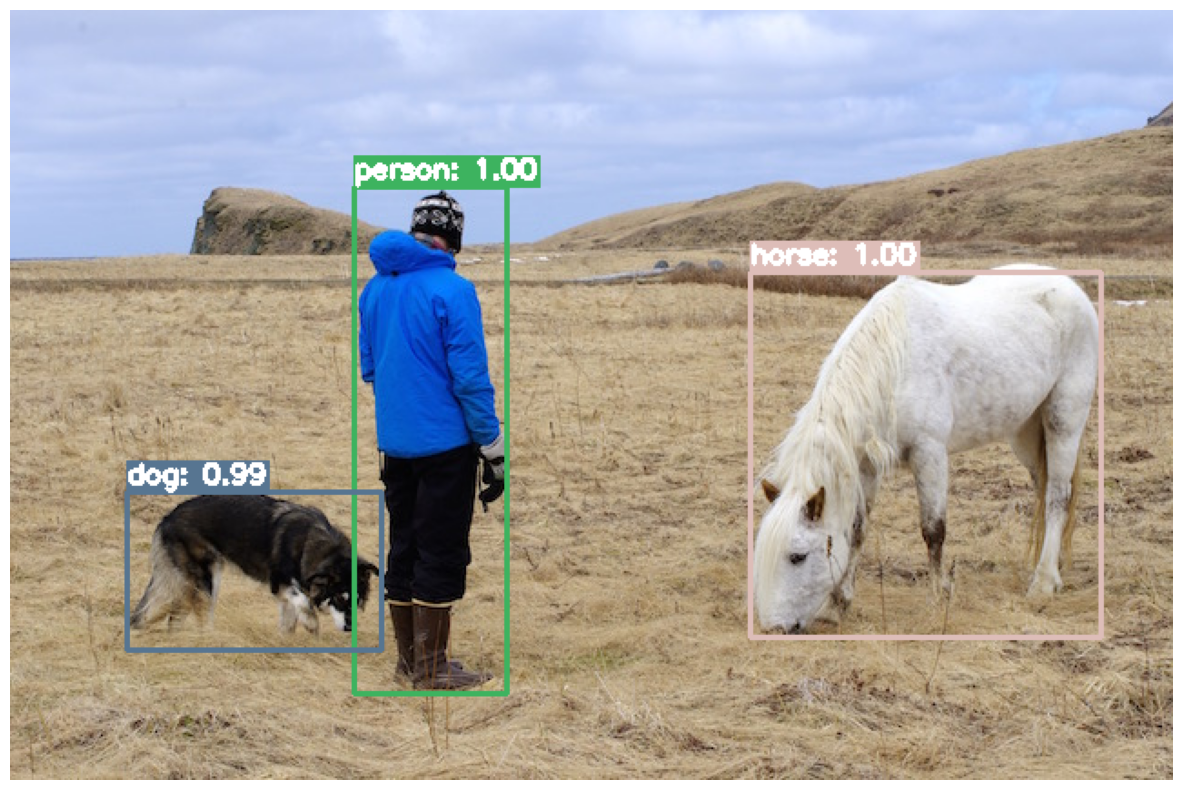

Detecciones realizadas: 3
Objetos encontrados:
- person: 1.00
- horse: 1.00
- dog: 0.99


Procesando imagen: https://raw.githubusercontent.com/pjreddie/darknet/master/data/horses.jpg


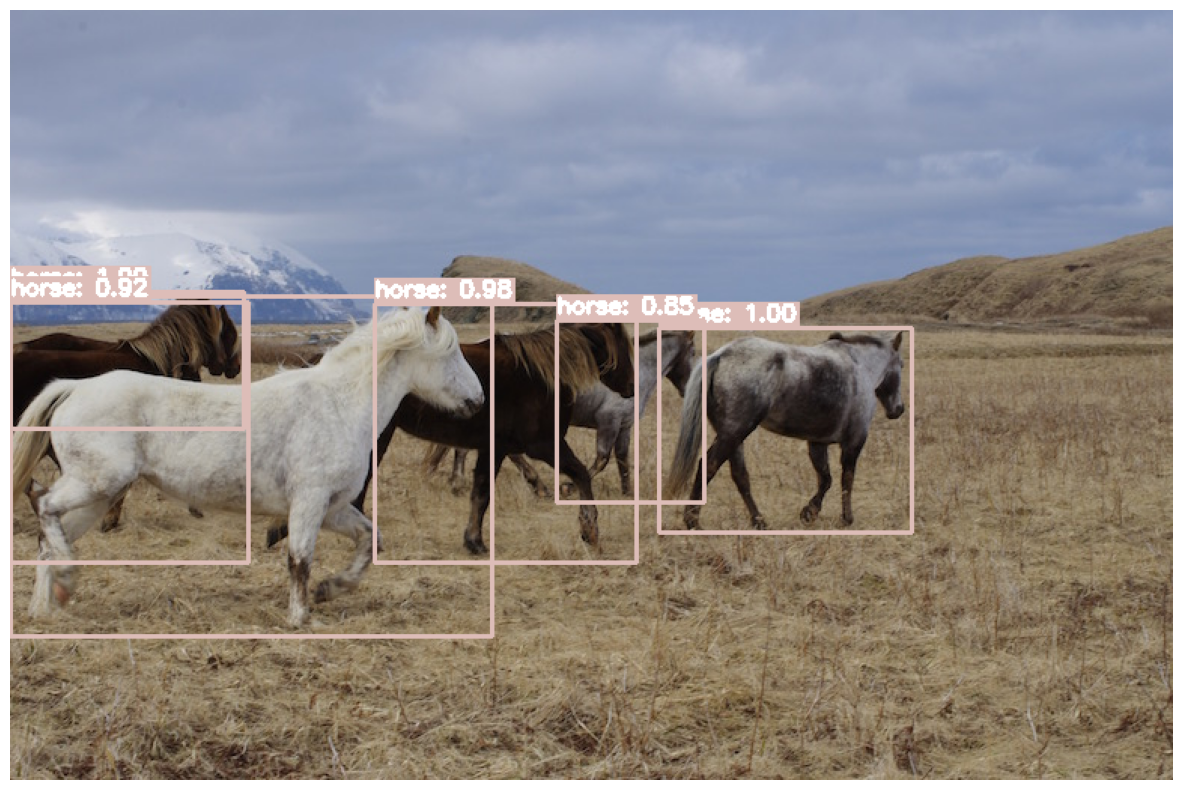

Detecciones realizadas: 6
Objetos encontrados:
- horse: 1.00
- horse: 1.00
- horse: 1.00
- horse: 0.98
- horse: 0.92
- horse: 0.85


Procesando imagen: https://raw.githubusercontent.com/pjreddie/darknet/master/data/scream.jpg


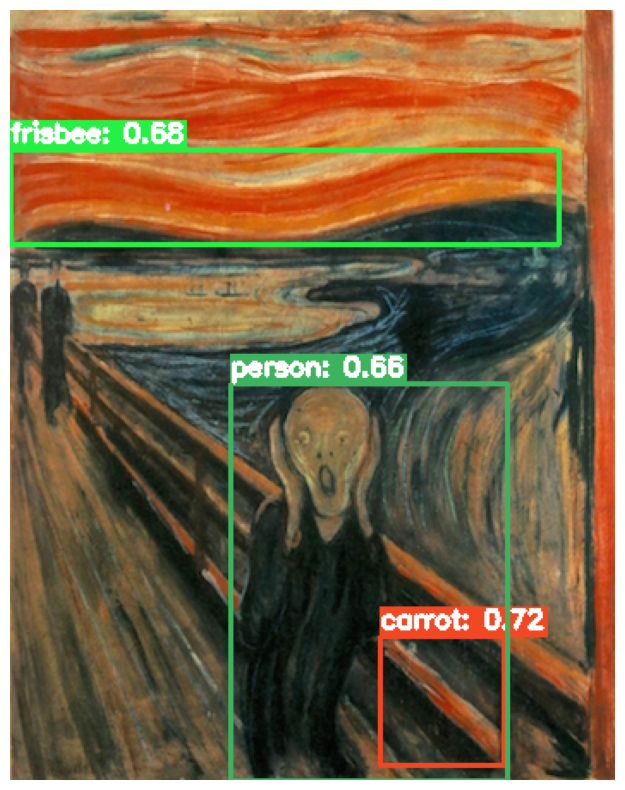

Detecciones realizadas: 3
Objetos encontrados:
- carrot: 0.72
- frisbee: 0.68
- person: 0.66




In [8]:
def procesar_imagenes_ejemplo():
    # Lista de URLs de imágenes de ejemplo
    urls_ejemplo = [
        "https://github.com/pytorch/hub/raw/master/images/dog.jpg",
        "https://raw.githubusercontent.com/pjreddie/darknet/master/data/person.jpg",
        "https://raw.githubusercontent.com/pjreddie/darknet/master/data/horses.jpg",
        "https://raw.githubusercontent.com/pjreddie/darknet/master/data/scream.jpg",
    ]

    for url in urls_ejemplo:
        print(f"Procesando imagen: {url}")

        # Detectar objetos
        img, boxes, labels, scores = detectar_objetos(modelo, url, categorias)

        # Visualizar resultados
        img_resultado = visualizar_detecciones(img, boxes, labels, scores, categorias)

        print(f"Detecciones realizadas: {len(boxes)}")
        print("Objetos encontrados:")
        for label, score in zip(labels, scores):
            print(f"- {categorias[label]}: {score:.2f}")
        print("\n")

# Ejecutar ejemplos
procesar_imagenes_ejemplo()

# Procesar Imagen

Por favor, sube una imagen...


Saving 5.jpg to 5.jpg
Procesando imagen: 5.jpg


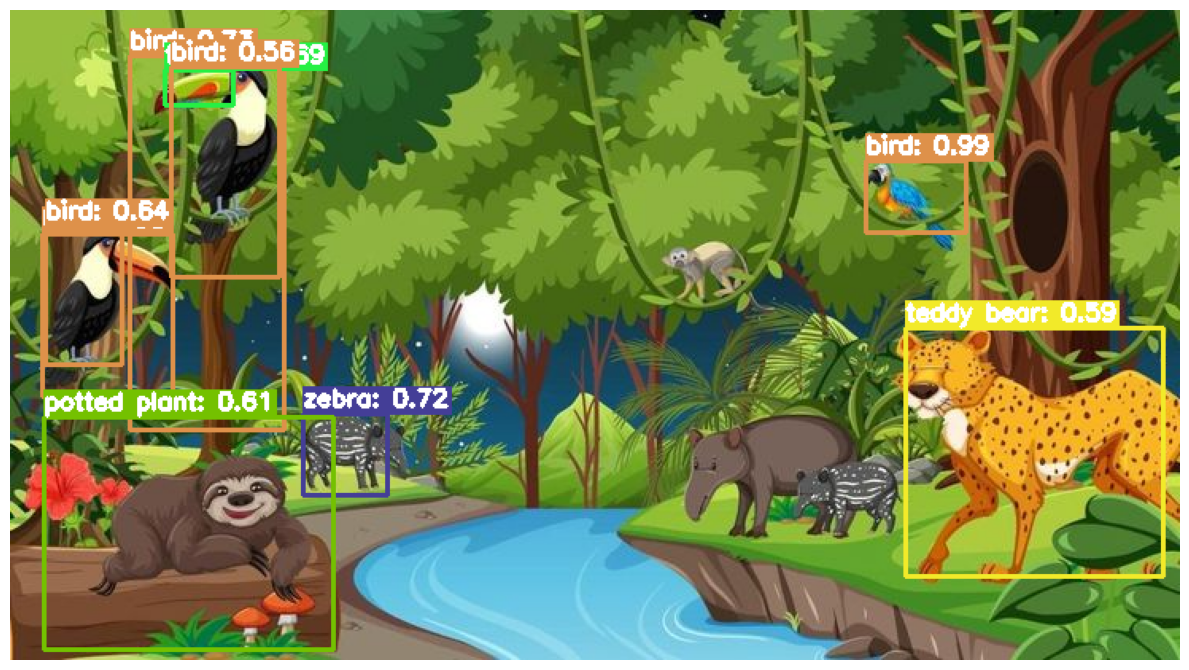

Detecciones realizadas: 9
Objetos encontrados:
- bird: 0.99
- bird: 0.98
- bird: 0.73
- zebra: 0.72
- frisbee: 0.69
- bird: 0.64
- potted plant: 0.61
- teddy bear: 0.59
- bird: 0.56


In [12]:
from google.colab import files

def procesar_imagen_usuario(umbral=0.5):
    """
    Permite al usuario subir una imagen y realizar detección de objetos.

    Args:
        umbral: Umbral de confianza para mostrar detecciones
    """
    print("Por favor, sube una imagen...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Procesando imagen: {filename}")

        # Abrir imagen
        img_path = filename

        # Detectar objetos
        img, boxes, labels, scores = detectar_objetos(modelo, img_path, categorias, umbral_confianza=umbral)

        # Visualizar resultados
        img_resultado = visualizar_detecciones(img, boxes, labels, scores, categorias)

        print(f"Detecciones realizadas: {len(boxes)}")
        print("Objetos encontrados:")
        for label, score in zip(labels, scores):
            print(f"- {categorias[label]}: {score:.2f}")

procesar_imagen_usuario()

# Efecto de umbral de confianza

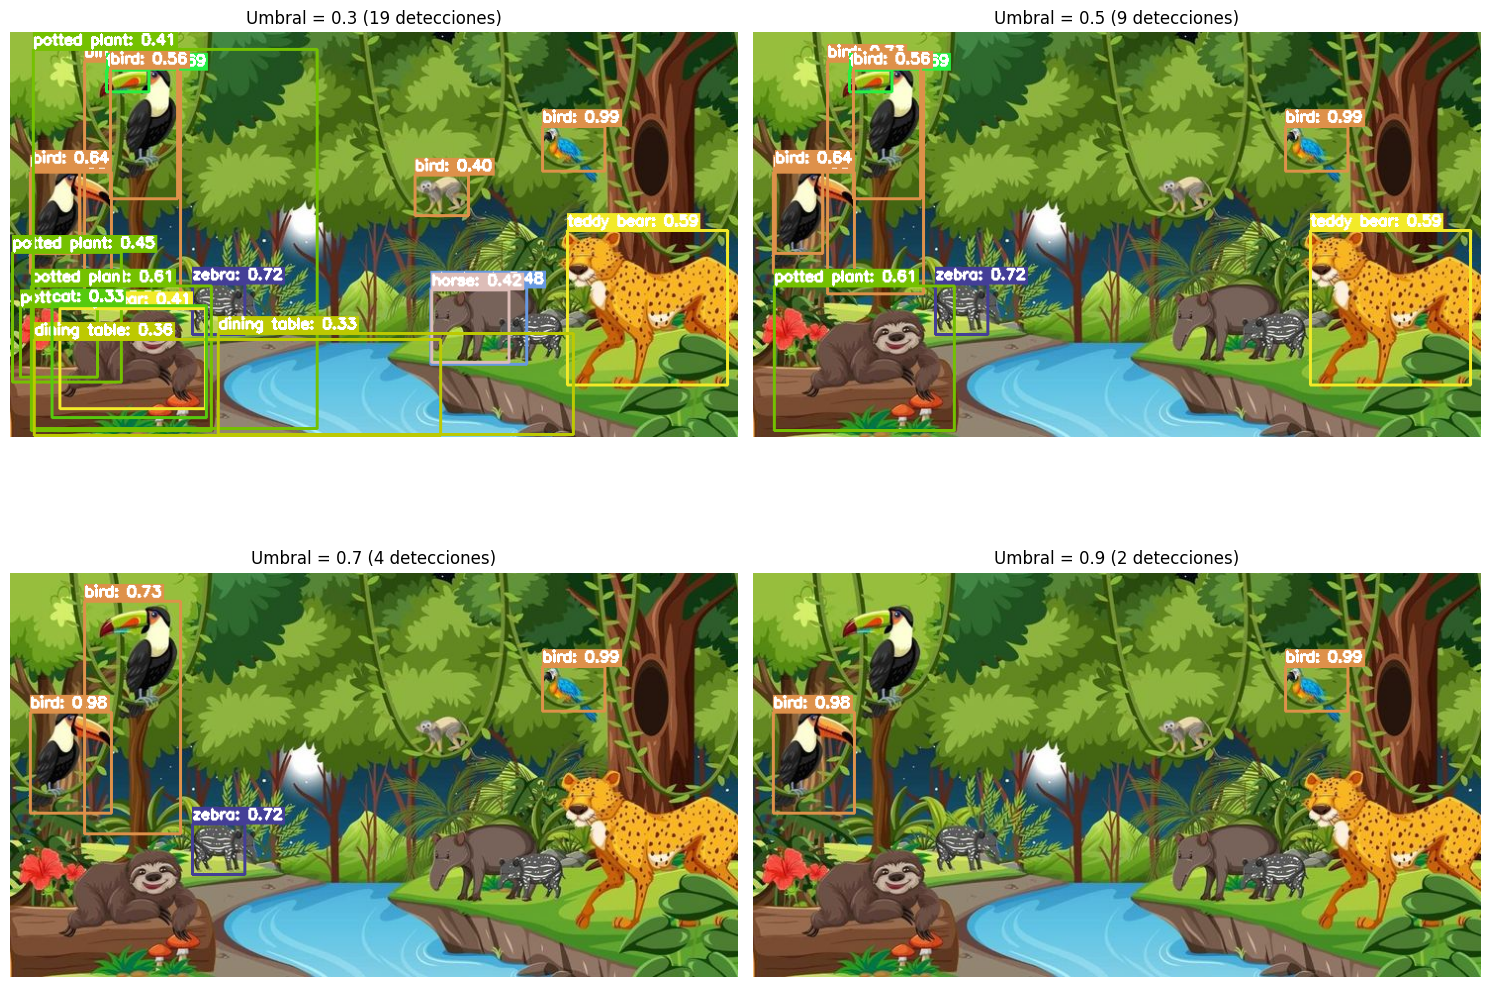

In [14]:
def experimentar_umbrales(imagen_url):
    """
    Muestra detecciones con diferentes umbrales de confianza

    Args:
        imagen_url: URL de la imagen a procesar
    """
    umbrales = [0.3, 0.5, 0.7, 0.9]
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.flatten()

    for i, umbral in enumerate(umbrales):
        # Detectar objetos con el umbral actual
        img, boxes, labels, scores = detectar_objetos(modelo, imagen_url, categorias, umbral_confianza=umbral)

        # Convertir a array numpy para manipulación con OpenCV
        img_np = np.array(img)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # Colores aleatorios para cada clase
        np.random.seed(42)
        colors = np.random.randint(0, 255, size=(len(categorias), 3), dtype=np.uint8)

        # Dibujar cajas delimitadoras
        for caja, etiqueta, puntuacion in zip(boxes, labels, scores):
            x1, y1, x2, y2 = caja
            color = tuple(map(int, colors[etiqueta]))
            cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)

            texto = f"{categorias[etiqueta]}: {puntuacion:.2f}"
            text_size = cv2.getTextSize(texto, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            cv2.rectangle(img_np, (x1, y1 - text_size[1] - 5), (x1 + text_size[0], y1), color, -1)
            cv2.putText(img_np, texto, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Mostrar en el subplot correspondiente
        axs[i].imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f"Umbral = {umbral} ({len(boxes)} detecciones)")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Ejecutar experimentación con una imagen de ejemplo
experimentar_umbrales("/content/5.jpg")
